In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.integrate import trapezoid, solve_ivp

<p align="center">
  <img src="https://github.com/marcus-valmeida/Projeto-conversao/blob/medupl/circuito_exercicio2.png?raw=true" alt="Circuito Exercício 1" width="500"/>
</p>

In [ ]:
#Dados da questão
R = 4*1e-2
D = 15*1e-2
N1  = 90
lc = 25*1e-2
U0  = 4*np.pi*1e-7
alpha  = np.pi / 3

num_pontos = 200

#caso real
CampoMagnetico = np.array([0, 68, 135, 203, 271, 338, 406, 474, 542, 609, 1100, 1500, 2500, 4000, 5000, 9000, 12000, 20000, 25000])
DensidadeCampo = np.array([0, 0.733, 1.205, 1.424, 1.517, 1.560, 1.588, 1.617, 1.631, 1.646, 1.689, 1.703,1.724, 1.731, 1.738, 1.761, 1.770, 1.800, 1.816])

#caso linear
CampoMagnetico_linear = np.array([0, 68])
DensidadeCampo_linear = np.array([0, 0.733])

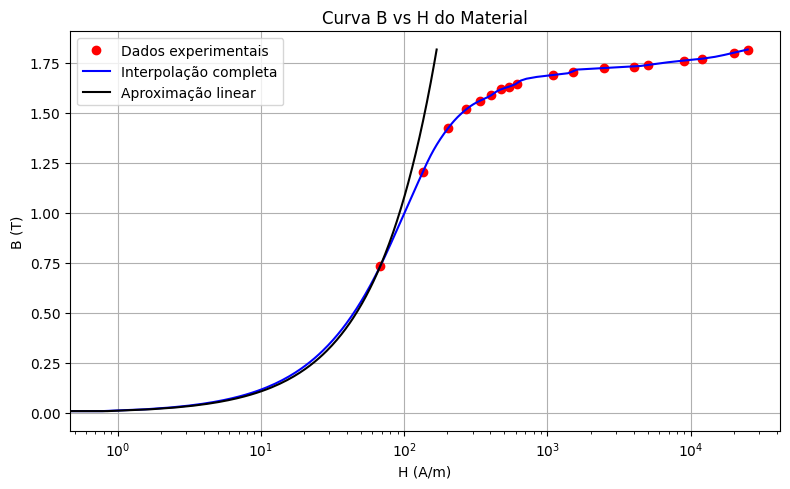

In [3]:
# Interpolação cúbica (ordem crescente de B)
f_real = CubicSpline(DensidadeCampo, CampoMagnetico, bc_type='natural')
f_linear = CubicSpline(DensidadeCampo_linear, CampoMagnetico_linear, bc_type='natural')

# Geração de pontos para interpolação
B_a = np.linspace(min(DensidadeCampo), max(DensidadeCampo), num_pontos)
H_a = f_real(B_a)
H_linear_a = f_linear(B_a)

# Plotagem
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(CampoMagnetico, DensidadeCampo, 'ro', label='Dados experimentais')
ax.plot(H_a, B_a, 'b-', label='Interpolação completa')
ax.plot(H_linear_a, B_a, 'k-', label='Aproximação linear')

ax.set_title('Curva B vs H do Material')
ax.set_xlabel('H (A/m)')
ax.set_ylabel('B (T)')
ax.set_xscale('log')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

#### Considere que o controlador do sistema aplica corrente em apenas uma bobina de cada vez.

- Apresente um gráfico do fluxo concatenado na bobina 1 em função da corrente aplicada nessa bobina considerando a posição do rotor variando da posição 0° até 60°.
    - Observação: seu gráfico terá uma curva de fluxo em função da corrente para cada posição. Se
você fizer o plot para todas as posições que calcular, a figura fica sobre carregada. Sugiro
fazer o plot com cerca de 10 posições diferentes ( ou seja, 0, 6, 12... 60°).

In [ ]:
def area_eficaz(theta):

    #limitando de 0 a 360 graus
    theta = np.mod(theta, 2*np.pi)

    #0 até 30 graus
    if (0 <= theta <= np.pi/6):
        return R * D * (np.pi - theta)
    
    #30 até 60 graus ou 120 até 150 graus
    elif (np.pi/6 < theta <= np.pi/3) or (2*np.pi/3 < theta <= 5*np.pi/6):
        return R * D * (np.pi/6)
    
    #150 até 180 graus
    elif (5*np.pi/6 < theta <= np.pi):
        return R * D * (theta - 2*np.pi/3)
    
    else :
        return 0
    